In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.gen_tables.gen_table_pair as gen_table_pair
import data.scripts.predict.predict_slowdown as predict

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Pair - dynamic

In [129]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
intra_pkl = os.path.join(PKL_PATH, 'intra.pkl')
csv = os.path.join(HOME, 'data/csv/pair_dynamic.csv')
output = os.path.join(PKL_PATH, 'pair_dynamic.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --intra_pkl $intra_pkl 

(1905, 44)


In [130]:
df_dynamic = pd.read_pickle(output)
print(df_dynamic.shape)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)

# FIXME: drop any rows with zero fairness
df_dynamic = df_dynamic[df_dynamic['fairness'] > 0]



(1905, 255)


# Prediction Model

In [229]:
X, y = predict.prepare_datasets(df_dynamic)
model = predict.train(X, y)

X invalid? True
y invalid? False
X invalid? True
y invalid? False
(3810, 15) (3810,)
K-fold l1 error: 0.02460919129328545
K-fold l1 error: 0.024335247426257492
K-fold l1 error: 0.023192326091731833
K-fold l1 error: 0.02364162297978247
K-fold l1 error: 0.022076492341709213


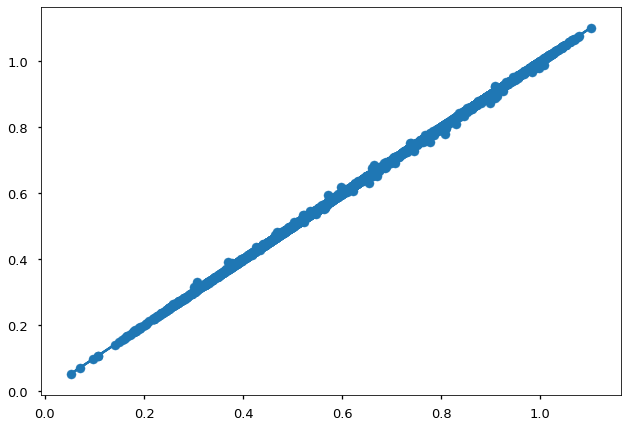

In [230]:
plt.scatter(y, model.predict(X))
plt.plot(y, y)
plt.show()

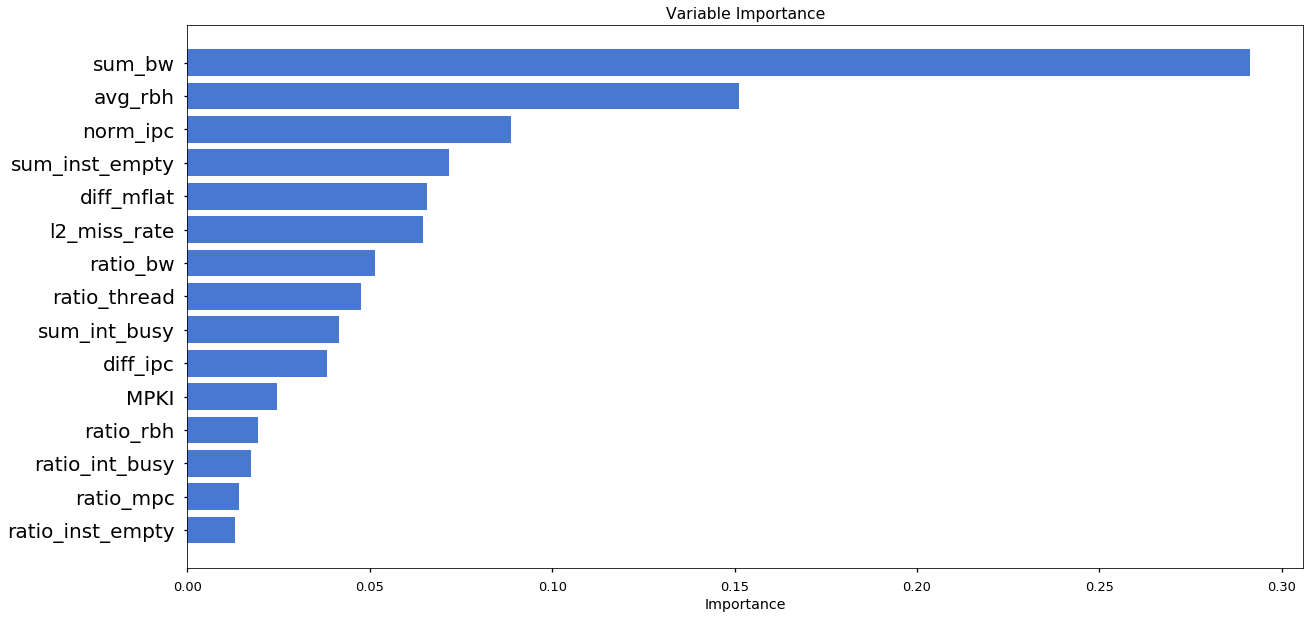

In [247]:
sns.set_palette(sns.color_palette("muted"))
predict.plot_importance(model)

In [232]:
df_dynamic['1_predicted'] = predict.predict_from_df(model, df_dynamic, 'x')
df_dynamic['2_predicted'] = predict.predict_from_df(model, df_dynamic, 'y')

df_dynamic['1_delta'] = (df_dynamic['1_predicted'] - df_dynamic['1_sld'])
df_dynamic['2_delta'] = (df_dynamic['2_predicted'] - df_dynamic['2_sld'])

In [233]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_seq = ['1_bench', 'intra_x',
                   '2_bench', 'intra_y',
#                    'norm_ipc_x', 
                   '1_sld', '1_predicted',  #'1_infer', 
                   '1_delta',
#                    'diff_rbh_x', 'diff_mflat_x', 'diff_bw_x', 'diff_mpc_x', 'diff_thread_x', 'l2_miss_rate_x',
#                    'norm_ipc_y', 
                   '2_sld', '2_predicted',  #'2_infer', 
                   '2_delta',
                   'ws', 'fairness', 
#                    'sum_ipc', 'diff_mflat', 'sum_dram',
#                    '1_norm_mflat', '2_norm_mflat'
                  ]
def highlight_error(s):
    is_high = np.abs(s) > 0.02
    return ['background-color: yellow' if v else '' for v in is_high]

# df_display = df_dynamic[(df_dynamic['1_bench']=='parb_cutcp-0') & \
#                         (df_dynamic['2_bench']=='rod_lavamd-0') #& \
# #                         (df_dynamic['intra_y'] == 2)
#                        ].sort_values(['intra_x', 'intra_y'])
df_display = df_dynamic[(df_dynamic['1_delta'] > 0.02) | (df_dynamic['2_delta'] > 0.02) | (df_dynamic['1_delta'] < -0.02) | (df_dynamic['2_delta'] < -0.02)]
draw_table(df_display, 
           col_dynamic_seq, False).apply(highlight_error, subset=['1_delta', '2_delta'])

,1_bench,intra_x,2_bench,intra_y,1_sld,1_predicted,1_delta,2_sld,2_predicted,2_delta,ws,fairness
13,cut_sgemm-1,1,nvd_sobol-0,12,0.370055,0.390092,0.0200363,0.746868,0.746165,-0.000702943,1.11692,0.495476
39,cut_sgemm-1,1,rod_hotspot-0,3,0.443,0.442187,-0.000813035,0.777523,0.75496,-0.0225632,1.22052,0.569758
128,nvd_binomial-0,8,nvd_interval-0,6,0.64883,0.652786,0.00395568,0.572465,0.59446,0.021995,1.22129,0.882303
628,nvd_blackscholes-0,4,rod_hotspot-0,3,0.810492,0.808438,-0.00205449,0.653836,0.632371,-0.0214647,1.46433,0.806715
633,nvd_blackscholes-0,6,rod_hotspot-0,4,0.845222,0.846159,0.000936674,0.597328,0.618238,0.0209098,1.44255,0.706712
690,nvd_interval-0,9,nvd_sobol-0,12,0.663984,0.686733,0.022749,0.741676,0.740167,-0.0015082,1.40566,0.895248
790,nvd_interval-0,6,parb_spmv-0,9,0.89938,0.874787,-0.0245923,0.853293,0.853089,-0.000204923,1.75267,0.948758
1775,parb_stencil-0,2,rod_lavamd-0,8,0.306935,0.330077,0.0231423,0.85142,0.850993,-0.000426579,1.15835,0.360497
1879,rod_hotspot3d-0,5,rod_lavamd-0,3,0.914963,0.914284,-0.000678903,0.807197,0.781136,-0.0260614,1.72216,0.882219


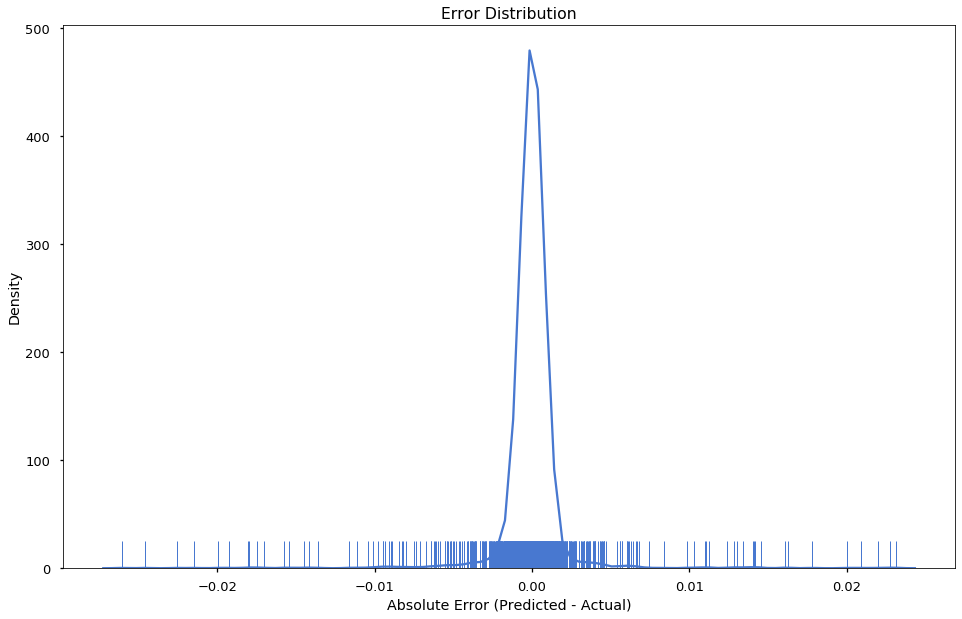

In [243]:
fig = plt.figure(figsize=(16, 10))
# get deltas
delta1 = df_dynamic['1_delta'].values
delta2 = df_dynamic['2_delta'].values
delta = np.concatenate((delta1, delta2))
# delta = delta * 100
plt.style.use('seaborn-talk')
sns.distplot(delta, hist=False, rug=True);
# sns.distplot(delta, bins=40, kde=False, rug=True);
plt.xlabel('Absolute Error (Predicted - Actual)')
plt.ylabel('Density')
plt.title('Error Distribution')
# plt.show()
fig.savefig(os.path.join(HOME, 'data/graphs/grad_boosting_err_dist.pdf'))



# Predict WS

In [155]:
X, y = predict.prepare_ws_datasets(df_dynamic)
ws_model = predict.train(X, y)

X invalid? False
y invalid? False
K-fold l1 error: 0.25432769306956776
K-fold l1 error: 0.2888159688504207
K-fold l1 error: 0.3039115833720339
K-fold l1 error: 0.2572117261101594


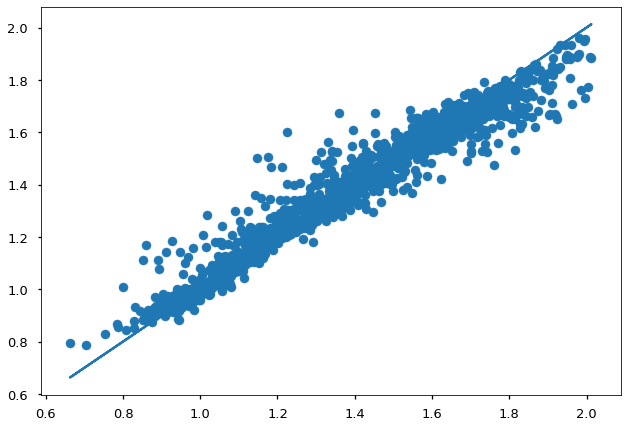

In [156]:
plt.scatter(y, ws_model.predictct(X))
plt.plot(y, y)
plt.show()

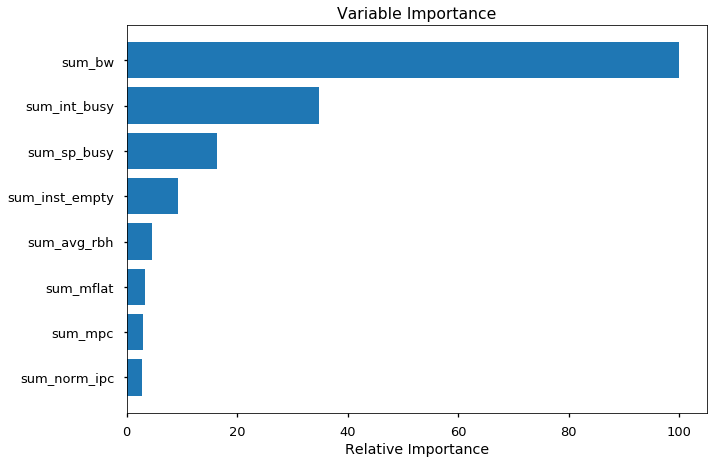

In [159]:
predict.plot_importance(ws_model, 'ws')

# L2 partition worth it?

In [522]:
# read csv file unified-l2.csv
df_l2 = pd.read_csv(os.path.join(CSV_PATH, 'unified-l2.csv'))

# split pair into two benchmarks
pair = [re.split(r'-(?=\D)', p) for p in df_l2['pair_str']]
df_bench = pd.DataFrame(pair, columns=['1_bench', '2_bench'])
df_l2 = pd.concat([df_bench, df_l2], axis=1)

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_l2 = gen_table_pair.evaluate_df_pair(df_l2, df_seq)

l2_keep_col = ['1_bench', '2_bench', '1_sld', '2_sld', 'ws', 'fairness']
df_yes_l2 = df_dynamic_show[l2_keep_col]
df_l2 = df_l2[l2_keep_col]

df_merge = pd.merge(df_l2, df_yes_l2, on=['1_bench', '2_bench'])
# draw_table(df_merge, df_merge.columns)

from scipy.stats import mstats
yes_ws = mstats.gmean(df_merge['ws_y'])
no_ws = mstats.gmean(df_merge['ws_x'])
yes_fair = mstats.gmean(df_merge['fairness_y'])
no_fair = mstats.gmean(df_merge['fairness_x'])

print(yes_ws, no_ws)
print(yes_fair, no_fair)

1.5916939808437316 1.5813796047349369
0.7997131123163216 0.8017260683214498


# Kernel Friendliness (Best WS)

In [117]:
subdf_1 = df_dynamic_show[['1_bench', '1_sld', '2_sld']].rename(
    columns={'1_bench':'Kernel', '1_sld':'Slowdown', '2_sld':'Slowdown (Other)'}).reset_index(drop=True)
print(subdf_1.head(5))
subdf_2 = df_dynamic_show[['2_bench', '2_sld', '1_sld']].rename(
    columns={'2_bench':'Kernel', '2_sld':'Slowdown', '1_sld':'Slowdown (Other)'}).reset_index(drop=True)

df_violin = pd.concat([subdf_1, subdf_2], axis=0)
df_violin = df_violin.sort_values('Kernel')

         Kernel  Slowdown  Slowdown (Other)
0  parb_cutcp-0  0.987002          1.021684
1  parb_cutcp-0  0.904176          1.097254
2  parb_cutcp-0  0.966800          1.033068
3  parb_cutcp-0  0.963224          0.976767
4    parb_lbm-0  0.929835          1.008986


In [130]:
# function to plot box plot
def my_boxplot(y_col, title):
    plt.figure(figsize=(16, 6))
    sns.scatterplot(x="Kernel", y=y_col, data=df_violin)
    ax = sns.boxplot(x="Kernel", y=y_col, data=df_violin)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim([0, 1.2])
    ax.set_title(title, fontsize=16)
    ax.tick_params(labelsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.xaxis.label.set_visible(False)
    
    plt.show()

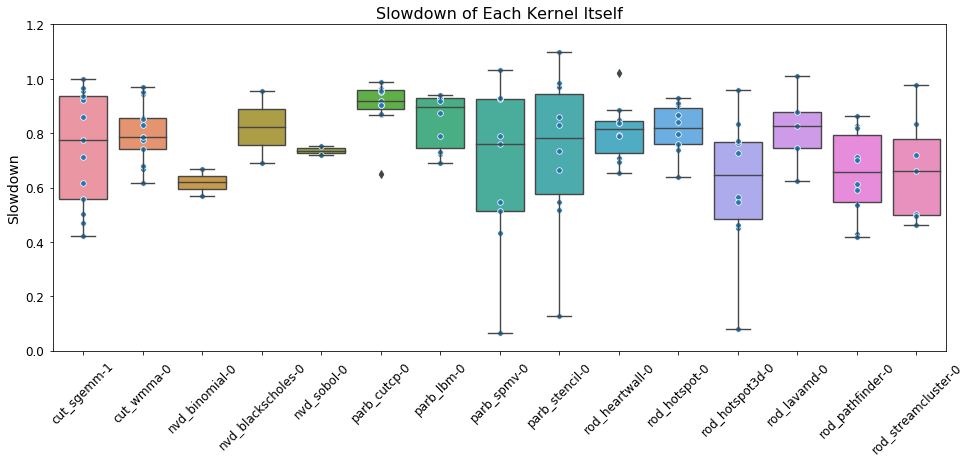

In [131]:
my_boxplot('Slowdown', 'Slowdown of Each Kernel Itself')

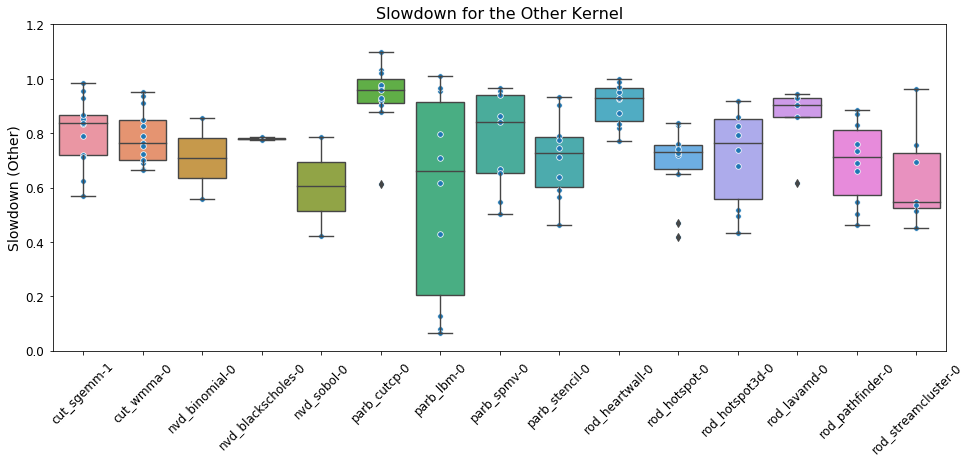

In [132]:
my_boxplot('Slowdown (Other)', 'Slowdown for the Other Kernel')